# Comparison


In [1]:
import pandas as pd
import numpy as np
import os
import pickle

pd.set_option("display.max_columns", None)

In [2]:
from scripts.params import get_params
from scripts.aux_functions import get_all_results_matching, subset_of_columns, clean_modelname

params = get_params()

In [3]:
from scripts.epftoolbox_dm_gw import DM, plot_multivariate_DM_test, GW, plot_multivariate_GW_test

In [4]:
dataroute = params["dataroute"]
resultsroute = params["resultsroute"]
dumproute = params["dumproute"]
graphsroute = params["graphsroute"]

In [5]:
start_test = params["start_test"]
local_suffix = params["local_suffix"]

In [6]:
name = f'finaldf_test_{params["tablename"]}.pickle'
filename = os.path.join(dataroute, name)
with open(filename, "rb") as handle:
    df_test = pickle.load(handle)
    
df_test.index=pd.to_datetime(df_test.index.copy())

In [7]:
all_forecasts = get_all_results_matching(params["resultsroute"], ["forecast"])
all_residuals = get_all_results_matching(params["resultsroute"], ["residual"])

{'GARCH_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\GARCH_BR_^BVSP_aic_best_forecasts.pickle', 'GARCH_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\GARCH_BR_^BVSP_bic_best_forecasts.pickle', 'HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle', 'HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle', 'HMM_univ_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_univ_BR_^BVSP_aic_best_forecasts.pickle', 'HMM_univ_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_univ_BR_^BVSP_bic_best_forecasts.pickle', 'HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle', 'HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle', 'VAR_multiv_BR_^BVSP_aic_best_forecasts.pickle': '.

In [8]:
def get_only_log_rets(dict_with_dfs: dict, stock: str):
    if type(dict_with_dfs[stock]) == pd.Series:
        # univariate models are saved as series
        df = pd.DataFrame(dict_with_dfs[stock])

    else:
        try:
            # multivariate models are saved as dataframes
            df = pd.DataFrame(dict_with_dfs[stock][f"{stock}_log_rets"])
        except:  # TODO: SACAR ESTO! Es un chanchullo pq hay algunas que son guardadas como None
            pass
    return df

In [9]:
def create_df_from_results_dict(results_dict:dict, substring_to_replace:str):
    created_df = pd.DataFrame()

    for name, dir in results_dict.items():
        dict_with_dfs = pd.read_pickle(dir)
        print(name)

        for stock in dict_with_dfs.keys():
            df = get_only_log_rets(dict_with_dfs, stock)

            modelname = clean_modelname(name, substring_to_replace, tablename=params["tablename"])

            df.columns = [modelname + "_" + stock]

            created_df = pd.merge(
                created_df, df, left_index=True, right_index=True, how="outer"
            )

    created_df.index = pd.to_datetime(created_df.index)
    created_df = created_df[created_df.index > start_test]
    return created_df

In [10]:
forecasts_df = create_df_from_results_dict(all_forecasts, "forecasts")
forecasts_df.tail(2)

GARCH_BR_^BVSP_aic_best_forecasts.pickle
GARCH_BR_^BVSP_bic_best_forecasts.pickle
HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle
HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle
HMM_univ_BR_^BVSP_aic_best_forecasts.pickle
HMM_univ_BR_^BVSP_bic_best_forecasts.pickle
HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle
HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle
VAR_multiv_BR_^BVSP_aic_best_forecasts.pickle
VAR_multiv_BR_^BVSP_bic_best_forecasts.pickle
VAR_with_vol_BR_^BVSP_aic_best_forecasts.pickle


VAR_with_vol_BR_^BVSP_bic_best_forecasts.pickle


,GARCH_BR_^BVSP_aic_best_forecasts.pickle_^BVSP,GARCH_BR_^BVSP_aic_best_forecasts.pickle_VALE3.SA,GARCH_BR_^BVSP_aic_best_forecasts.pickle_VALE,GARCH_BR_^BVSP_aic_best_forecasts.pickle_PETR3.SA,GARCH_BR_^BVSP_aic_best_forecasts.pickle_PBR,GARCH_BR_^BVSP_aic_best_forecasts.pickle_EMBR3.SA,GARCH_BR_^BVSP_aic_best_forecasts.pickle_ERJ,GARCH_BR_^BVSP_aic_best_forecasts.pickle_ABEV3.SA,GARCH_BR_^BVSP_aic_best_forecasts.pickle_ABEV,GARCH_BR_^BVSP_bic_best_forecasts.pickle_^BVSP,GARCH_BR_^BVSP_bic_best_forecasts.pickle_VALE3.SA,GARCH_BR_^BVSP_bic_best_forecasts.pickle_VALE,GARCH_BR_^BVSP_bic_best_forecasts.pickle_PETR3.SA,GARCH_BR_^BVSP_bic_best_forecasts.pickle_PBR,GARCH_BR_^BVSP_bic_best_forecasts.pickle_EMBR3.SA,GARCH_BR_^BVSP_bic_best_forecasts.pickle_ERJ,GARCH_BR_^BVSP_bic_best_forecasts.pickle_ABEV3.SA,GARCH_BR_^BVSP_bic_best_forecasts.pickle_ABEV,HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle_^BVSP,HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle_VALE3.SA,HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle_VALE,HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle_PETR3.SA,HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle_PBR,HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle_EMBR3.SA,HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle_ERJ,HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle_ABEV3.SA,HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle_ABEV,HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle_^BVSP,HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle_VALE3.SA,HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle_VALE,HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle_PETR3.SA,HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle_PBR,HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle_EMBR3.SA,HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle_ERJ,HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle_ABEV3.SA,HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle_ABEV,HMM_univ_BR_^BVSP_aic_best_forecasts.pickle_^BVSP,HMM_univ_BR_^BVSP_aic_best_forecasts.pickle_VALE3.SA,HMM_univ_BR_^BVSP_aic_best_forecasts.pickle_VALE,HMM_univ_BR_^BVSP_aic_best_forecasts.pickle_PETR3.SA,HMM_univ_BR_^BVSP_aic_best_forecasts.pickle_PBR,HMM_univ_BR_^BVSP_aic_best_forecasts.pickle_EMBR3.SA,HMM_univ_BR_^BVSP_aic_best_forecasts.pickle_ERJ,HMM_univ_BR_^BVSP_aic_best_forecasts.pickle_ABEV3.SA,HMM_univ_BR_^BVSP_aic_best_forecasts.pickle_ABEV,HMM_univ_BR_^BVSP_bic_best_forecasts.pickle_^BVSP,HMM_univ_BR_^BVSP_bic_best_forecasts.pickle_VALE3.SA,HMM_univ_BR_^BVSP_bic_best_forecasts.pickle_VALE,HMM_univ_BR_^BVSP_bic_best_forecasts.pickle_PETR3.SA,HMM_univ_BR_^BVSP_bic_best_forecasts.pickle_PBR,HMM_univ_BR_^BVSP_bic_best_forecasts.pickle_EMBR3.SA,HMM_univ_BR_^BVSP_bic_best_forecasts.pickle_ERJ,HMM_univ_BR_^BVSP_bic_best_forecasts.pickle_ABEV3.SA,HMM_univ_BR_^BVSP_bic_best_forecasts.pickle_ABEV,HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle_^BVSP,HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle_VALE3.SA,HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle_VALE,HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle_PETR3.SA,HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle_PBR,HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle_EMBR3.SA,HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle_ERJ,HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle_ABEV3.SA,HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle_ABEV,HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle_^BVSP,HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle_VALE3.SA,HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle_VALE,HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle_PETR3.SA,HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle_PBR,HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle_EMBR3.SA,HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle_ERJ,HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle_ABEV3.SA,HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle_ABEV,VAR_multiv_BR_^BVSP_aic_best_forecasts.pickle_^BVSP,VAR_multiv_BR_^BVSP_aic_best_forecasts.pickle_VALE3.SA,VAR_multiv_BR_^BVSP_aic_best_forecasts.pickle_VALE,VAR_multiv_BR_^BVSP_aic_best_forecasts.pickle_PETR3.SA,VAR_multiv_BR_^BVSP_aic_best_forecasts.pickle_PBR,VAR_multiv_BR_^BVSP_aic_best_forec

In [11]:
residual_df = create_df_from_results_dict(all_residuals, "residuals")
residual_df.head(2)

GARCH_BR_^BVSP_aic_best_residuals.pickle
GARCH_BR_^BVSP_bic_best_residuals.pickle
HMM_multiv_BR_^BVSP_aic_best_residuals.pickle
HMM_multiv_BR_^BVSP_bic_best_residuals.pickle
HMM_univ_BR_^BVSP_aic_best_residuals.pickle
HMM_univ_BR_^BVSP_bic_best_residuals.pickle
HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle
HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle
VAR_multiv_BR_^BVSP_aic_best_residuals.pickle
VAR_multiv_BR_^BVSP_bic_best_residuals.pickle
VAR_with_vol_BR_^BVSP_aic_best_residuals.pickle
VAR_with_vol_BR_^BVSP_bic_best_residuals.pickle


,GARCH_BR_^BVSP_aic_best_residuals.pickle_^BVSP,GARCH_BR_^BVSP_aic_best_residuals.pickle_VALE3.SA,GARCH_BR_^BVSP_aic_best_residuals.pickle_VALE,GARCH_BR_^BVSP_aic_best_residuals.pickle_PETR3.SA,GARCH_BR_^BVSP_aic_best_residuals.pickle_PBR,GARCH_BR_^BVSP_aic_best_residuals.pickle_EMBR3.SA,GARCH_BR_^BVSP_aic_best_residuals.pickle_ERJ,GARCH_BR_^BVSP_aic_best_residuals.pickle_ABEV3.SA,GARCH_BR_^BVSP_aic_best_residuals.pickle_ABEV,GARCH_BR_^BVSP_bic_best_residuals.pickle_^BVSP,GARCH_BR_^BVSP_bic_best_residuals.pickle_VALE3.SA,GARCH_BR_^BVSP_bic_best_residuals.pickle_VALE,GARCH_BR_^BVSP_bic_best_residuals.pickle_PETR3.SA,GARCH_BR_^BVSP_bic_best_residuals.pickle_PBR,GARCH_BR_^BVSP_bic_best_residuals.pickle_EMBR3.SA,GARCH_BR_^BVSP_bic_best_residuals.pickle_ERJ,GARCH_BR_^BVSP_bic_best_residuals.pickle_ABEV3.SA,GARCH_BR_^BVSP_bic_best_residuals.pickle_ABEV,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_^BVSP,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_VALE3.SA,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_VALE,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_PETR3.SA,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_PBR,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_EMBR3.SA,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_ERJ,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_ABEV3.SA,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_ABEV,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_^BVSP,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_VALE3.SA,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_VALE,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_PETR3.SA,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_PBR,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_EMBR3.SA,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_ERJ,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_ABEV3.SA,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_ABEV,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_^BVSP,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_VALE3.SA,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_VALE,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_PETR3.SA,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_PBR,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_EMBR3.SA,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_ERJ,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_ABEV3.SA,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_ABEV,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_^BVSP,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_VALE3.SA,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_VALE,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_PETR3.SA,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_PBR,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_EMBR3.SA,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_ERJ,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_ABEV3.SA,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_ABEV,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_^BVSP,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_VALE3.SA,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_VALE,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_PETR3.SA,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_PBR,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_EMBR3.SA,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_ERJ,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_ABEV3.SA,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_ABEV,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_^BVSP,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_VALE3.SA,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_VALE,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_PETR3.SA,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_PBR,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_EMBR3.SA,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_ERJ,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_ABEV3.SA,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_ABEV,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_^BVSP,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_VALE3.SA,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_VALE,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_PETR3.SA,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_PBR,VAR_multiv_BR_^BVSP_aic_best_resid

In [12]:
lower_date=pd.to_datetime(params["start_test"])+pd.Timedelta(days=1)
higher_date=pd.to_datetime(params["end_test"])-pd.Timedelta(days=1)
residual_df=residual_df[lower_date:higher_date].copy()
df_test = df_test[lower_date:higher_date].copy()
residual_df.head()

,GARCH_BR_^BVSP_aic_best_residuals.pickle_^BVSP,GARCH_BR_^BVSP_aic_best_residuals.pickle_VALE3.SA,GARCH_BR_^BVSP_aic_best_residuals.pickle_VALE,GARCH_BR_^BVSP_aic_best_residuals.pickle_PETR3.SA,GARCH_BR_^BVSP_aic_best_residuals.pickle_PBR,GARCH_BR_^BVSP_aic_best_residuals.pickle_EMBR3.SA,GARCH_BR_^BVSP_aic_best_residuals.pickle_ERJ,GARCH_BR_^BVSP_aic_best_residuals.pickle_ABEV3.SA,GARCH_BR_^BVSP_aic_best_residuals.pickle_ABEV,GARCH_BR_^BVSP_bic_best_residuals.pickle_^BVSP,GARCH_BR_^BVSP_bic_best_residuals.pickle_VALE3.SA,GARCH_BR_^BVSP_bic_best_residuals.pickle_VALE,GARCH_BR_^BVSP_bic_best_residuals.pickle_PETR3.SA,GARCH_BR_^BVSP_bic_best_residuals.pickle_PBR,GARCH_BR_^BVSP_bic_best_residuals.pickle_EMBR3.SA,GARCH_BR_^BVSP_bic_best_residuals.pickle_ERJ,GARCH_BR_^BVSP_bic_best_residuals.pickle_ABEV3.SA,GARCH_BR_^BVSP_bic_best_residuals.pickle_ABEV,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_^BVSP,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_VALE3.SA,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_VALE,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_PETR3.SA,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_PBR,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_EMBR3.SA,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_ERJ,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_ABEV3.SA,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_ABEV,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_^BVSP,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_VALE3.SA,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_VALE,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_PETR3.SA,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_PBR,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_EMBR3.SA,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_ERJ,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_ABEV3.SA,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_ABEV,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_^BVSP,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_VALE3.SA,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_VALE,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_PETR3.SA,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_PBR,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_EMBR3.SA,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_ERJ,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_ABEV3.SA,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_ABEV,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_^BVSP,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_VALE3.SA,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_VALE,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_PETR3.SA,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_PBR,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_EMBR3.SA,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_ERJ,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_ABEV3.SA,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_ABEV,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_^BVSP,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_VALE3.SA,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_VALE,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_PETR3.SA,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_PBR,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_EMBR3.SA,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_ERJ,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_ABEV3.SA,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_ABEV,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_^BVSP,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_VALE3.SA,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_VALE,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_PETR3.SA,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_PBR,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_EMBR3.SA,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_ERJ,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_ABEV3.SA,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_ABEV,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_^BVSP,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_VALE3.SA,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_VALE,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_PETR3.SA,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_PBR,VAR_multiv_BR_^BVSP_aic_best_resid

In [13]:
# estadisticos de nans
((residual_df.isna().sum(axis=0) / len(residual_df.index)) * 100).nlargest(10)

GARCH_BR_^BVSP_aic_best_residuals.pickle_^BVSP       0.0
GARCH_BR_^BVSP_aic_best_residuals.pickle_VALE3.SA    0.0
GARCH_BR_^BVSP_aic_best_residuals.pickle_VALE        0.0
GARCH_BR_^BVSP_aic_best_residuals.pickle_PETR3.SA    0.0
GARCH_BR_^BVSP_aic_best_residuals.pickle_PBR         0.0
GARCH_BR_^BVSP_aic_best_residuals.pickle_EMBR3.SA    0.0
GARCH_BR_^BVSP_aic_best_residuals.pickle_ERJ         0.0
GARCH_BR_^BVSP_aic_best_residuals.pickle_ABEV3.SA    0.0
GARCH_BR_^BVSP_aic_best_residuals.pickle_ABEV        0.0
GARCH_BR_^BVSP_bic_best_residuals.pickle_^BVSP       0.0
dtype: float64

In [14]:
# estadisticos de nans
((forecasts_df.isna().sum(axis=0) / len(forecasts_df.index)) * 100).nlargest(10)
# HMM tiene problemas con NANs

GARCH_BR_^BVSP_aic_best_forecasts.pickle_^BVSP       1.526718
GARCH_BR_^BVSP_aic_best_forecasts.pickle_VALE3.SA    1.526718
GARCH_BR_^BVSP_aic_best_forecasts.pickle_VALE        1.526718
GARCH_BR_^BVSP_aic_best_forecasts.pickle_PETR3.SA    1.526718
GARCH_BR_^BVSP_aic_best_forecasts.pickle_PBR         1.526718
GARCH_BR_^BVSP_aic_best_forecasts.pickle_EMBR3.SA    1.526718
GARCH_BR_^BVSP_aic_best_forecasts.pickle_ERJ         1.526718
GARCH_BR_^BVSP_aic_best_forecasts.pickle_ABEV3.SA    1.526718
GARCH_BR_^BVSP_aic_best_forecasts.pickle_ABEV        1.526718
GARCH_BR_^BVSP_bic_best_forecasts.pickle_^BVSP       1.526718
dtype: float64

## Separating in different stocks

In [15]:
def separate_by_stock(df:pd.DataFrame):
     stock_dict={}

     for stock in params["tickerlist"]:
          if params["local_suffix"] in stock:
               stock_dict[stock]= subset_of_columns(residual_df, stock)
          else:
               stock_dict[stock]= subset_of_columns(residual_df, stock, params["local_suffix"])    
     
     return stock_dict      

In [16]:
forecasts_by_stock=separate_by_stock(forecasts_df)
residuals_by_stock=separate_by_stock(residual_df)

In [17]:
def delete_in_column_names(df:pd.DataFrame, string:str):
    new_cols=[]
    for col in df.columns:
        col=col.replace(string, "")
        new_cols.append(col)
    df=df.set_axis(labels=new_cols, axis=1)
    return df

In [18]:
dmroute=os.path.join(graphsroute, "DM")
gwroute=os.path.join(graphsroute, "GW")

for folder_path in [dmroute, gwroute]:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path, exist_ok=True)

^BVSP


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


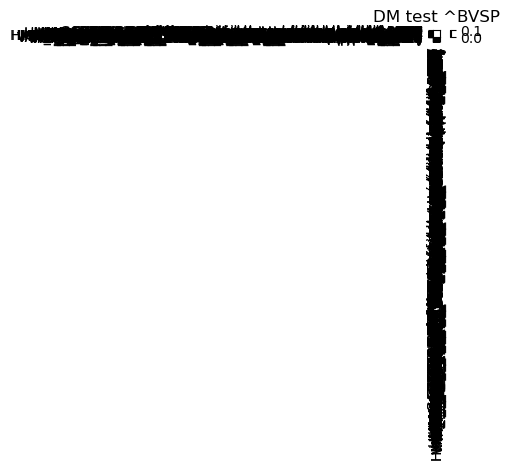

VALE3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:173: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


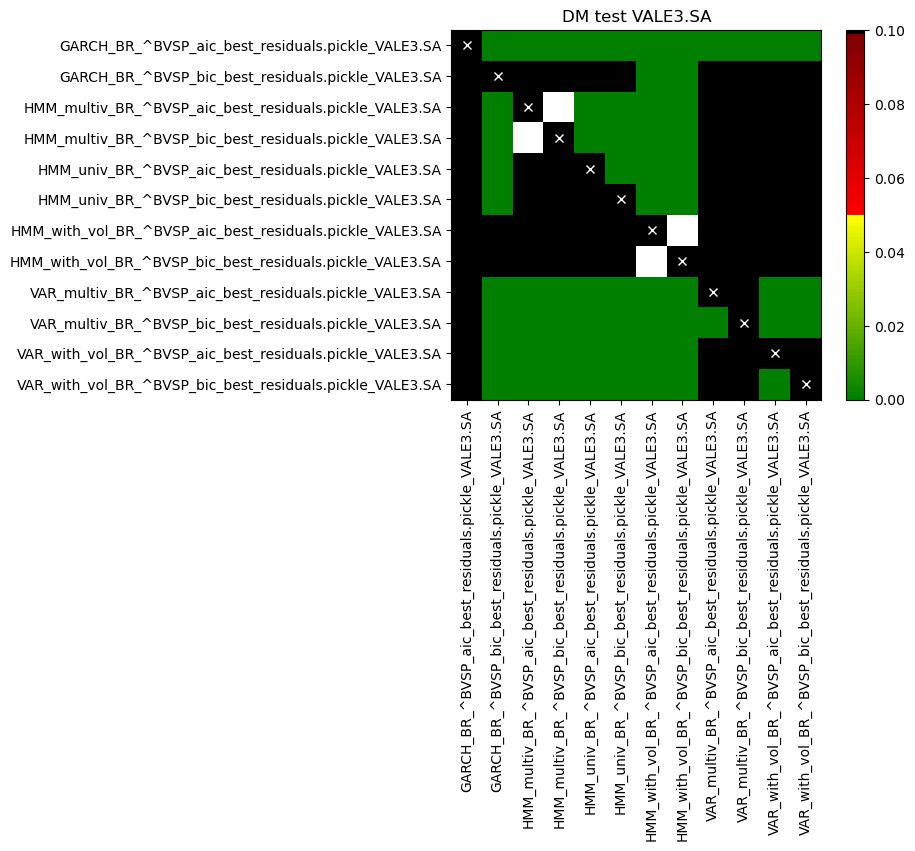

VALE


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


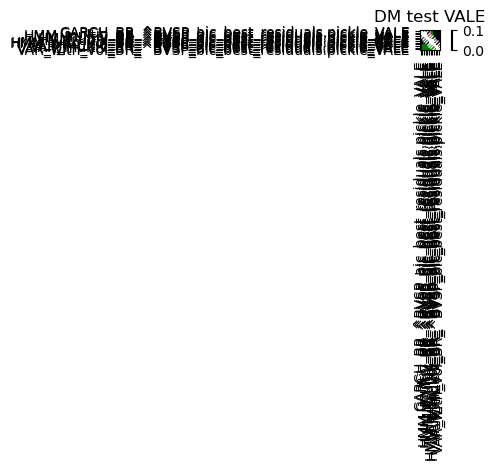

PETR3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:173: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


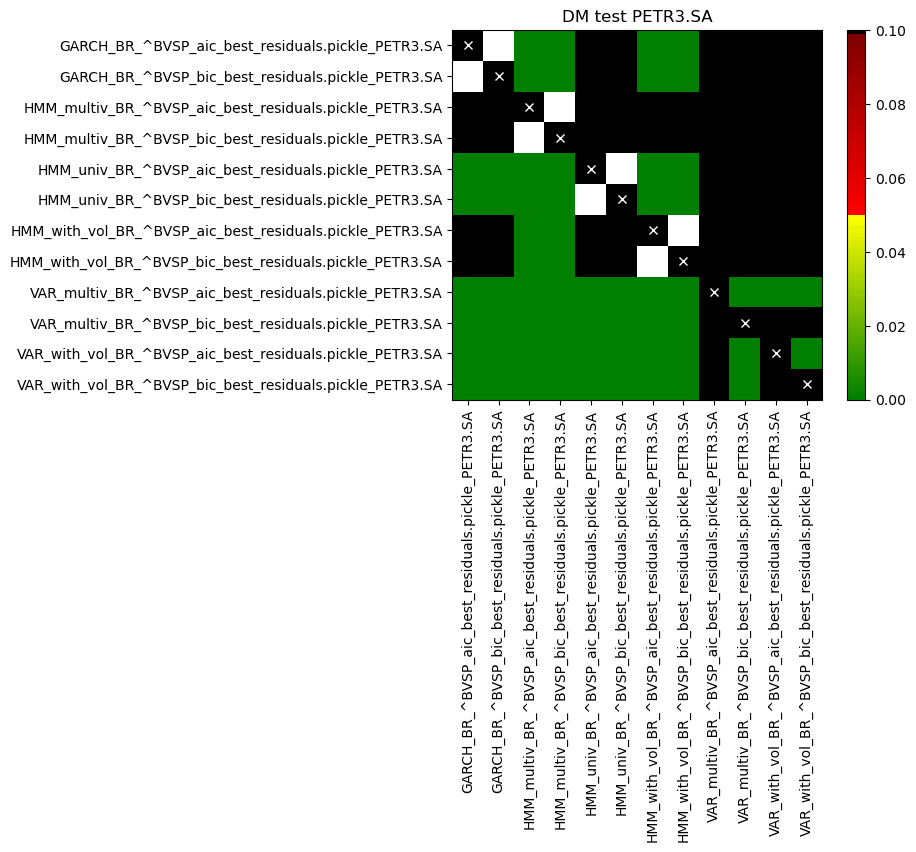

PBR


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


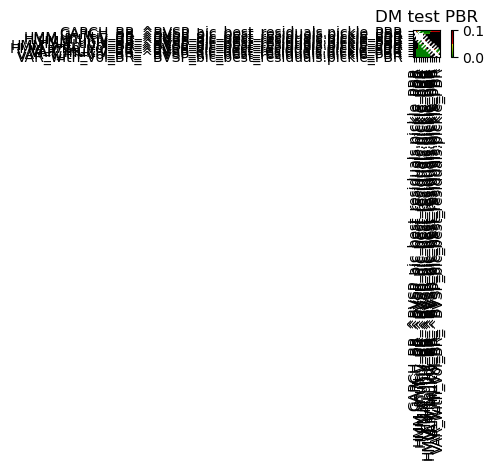

EMBR3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:173: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


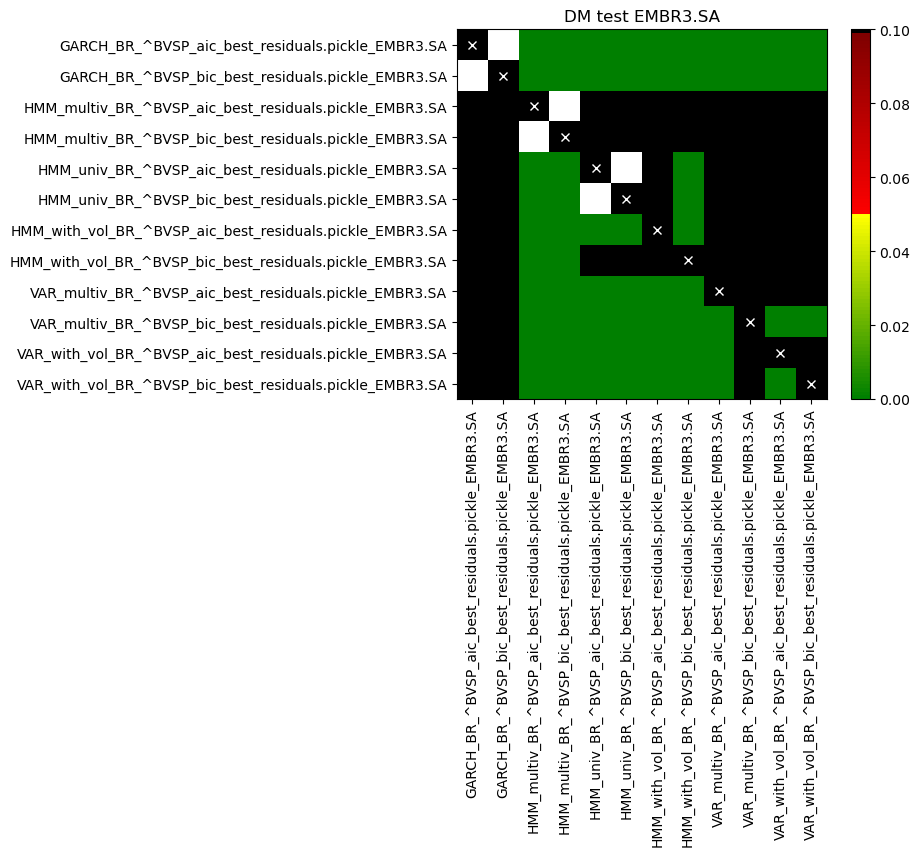

ERJ


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


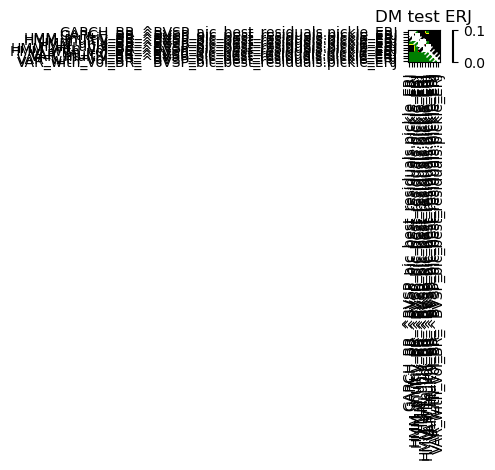

ABEV3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:173: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


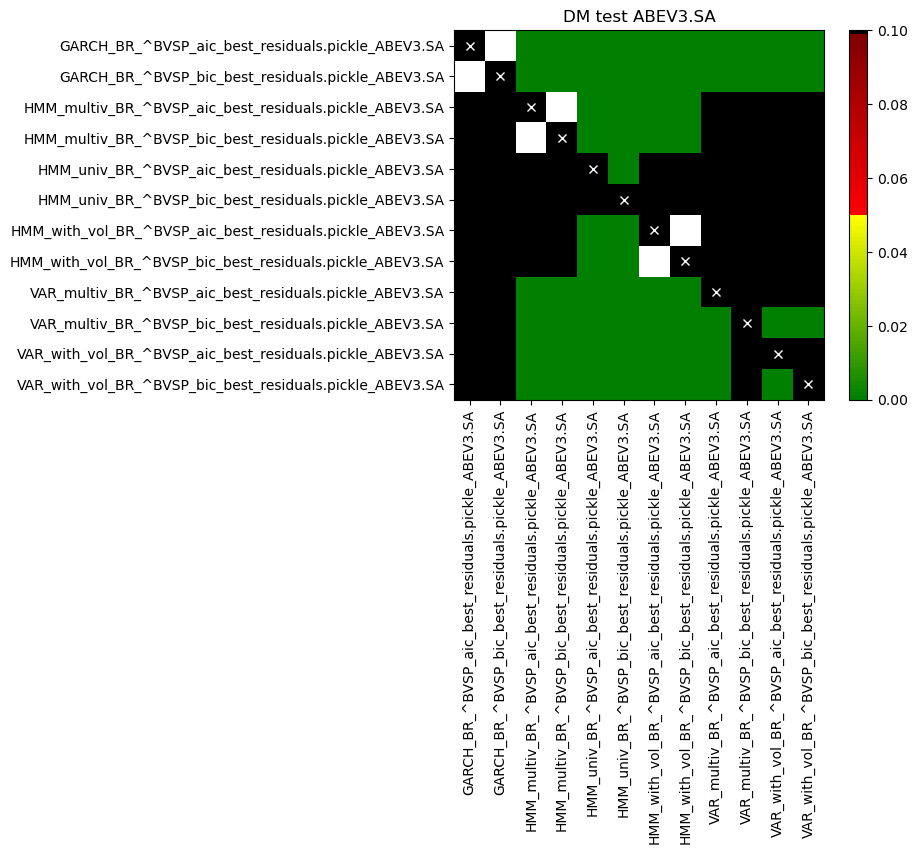

ABEV


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


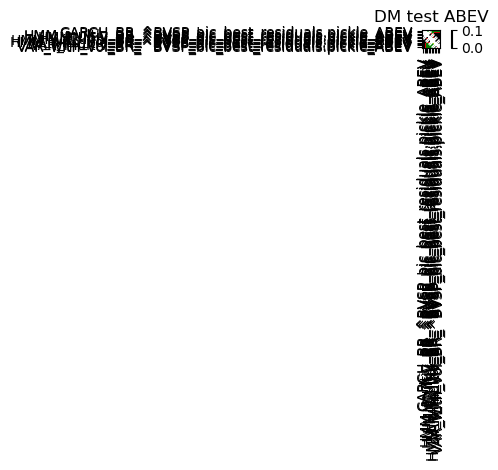

In [19]:
for stock in forecasts_by_stock.keys():
    print(stock)
    real_values=subset_of_columns(df_test, f"{stock}_log_rets")
    forecasts=delete_in_column_names(forecasts_by_stock[stock].fillna(0), f"__{stock}")   

    plot_multivariate_DM_test(real_price=real_values, 
                            forecasts=forecasts.fillna(0), 
                            title=f"DM test {stock}",
                            savefig=True,
                            path=dmroute)

In [20]:
best_models_by_stock={stock:None for stock in residuals_by_stock.keys()}

for stock, dataframe in residuals_by_stock.items():
    dataframe = delete_in_column_names(dataframe, f"__{stock}")
    metrics_df = pd.DataFrame(index=["mse", "meanabs", "medianabs"])

    for column in dataframe.columns:
        single_model=pd.DataFrame(dataframe[column])
        
        metrics_df.loc["mse", column] = (
            (single_model**2).mean().mean()
        )
        metrics_df.loc["meanabs", column] = (
            single_model.abs().mean().mean()
        )
        metrics_df.loc["medianabs", column] = (
            (single_model.abs()).median().median()
        )
    metrics_df = metrics_df * 100
        
    best_dict={}
    for criterion in metrics_df.index:
        best_dict[criterion] = metrics_df.iloc[metrics_df.index==criterion].idxmin(axis="columns").values[0]
        
    best_models_by_stock[stock]= (metrics_df, best_dict)

In [21]:
print(params["assetlist"][0])
best_models_by_stock[params["assetlist"][0]][1]

^BVSP


{'mse': 'VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_^BVSP',
 'meanabs': 'GARCH_BR_^BVSP_aic_best_residuals.pickle_^BVSP',
 'medianabs': 'VAR_multiv_BR_^BVSP_bic_best_residuals.pickle_^BVSP'}

In [22]:
best_models_by_stock[params["assetlist"][0]][0]

,GARCH_BR_^BVSP_aic_best_residuals.pickle_^BVSP,GARCH_BR_^BVSP_aic_best_residuals.pickle_VALE,GARCH_BR_^BVSP_aic_best_residuals.pickle_PBR,GARCH_BR_^BVSP_aic_best_residuals.pickle_ERJ,GARCH_BR_^BVSP_aic_best_residuals.pickle_ABEV,GARCH_BR_^BVSP_bic_best_residuals.pickle_^BVSP,GARCH_BR_^BVSP_bic_best_residuals.pickle_VALE,GARCH_BR_^BVSP_bic_best_residuals.pickle_PBR,GARCH_BR_^BVSP_bic_best_residuals.pickle_ERJ,GARCH_BR_^BVSP_bic_best_residuals.pickle_ABEV,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_^BVSP,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_VALE,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_PBR,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_ERJ,HMM_multiv_BR_^BVSP_aic_best_residuals.pickle_ABEV,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_^BVSP,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_VALE,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_PBR,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_ERJ,HMM_multiv_BR_^BVSP_bic_best_residuals.pickle_ABEV,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_^BVSP,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_VALE,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_PBR,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_ERJ,HMM_univ_BR_^BVSP_aic_best_residuals.pickle_ABEV,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_^BVSP,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_VALE,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_PBR,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_ERJ,HMM_univ_BR_^BVSP_bic_best_residuals.pickle_ABEV,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_^BVSP,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_VALE,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_PBR,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_ERJ,HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle_ABEV,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_^BVSP,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_VALE,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_PBR,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_ERJ,HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle_ABEV,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_^BVSP,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_VALE,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_PBR,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_ERJ,VAR_multiv_BR_^BVSP_aic_best_residuals.pickle_ABEV,VAR_multiv_BR_^BVSP_bic_best_residuals.pickle_^BVSP,VAR_multiv_BR_^BVSP_bic_best_residuals.pickle_VALE,VAR_multiv_BR_^BVSP_bic_best_residuals.pickle_PBR,VAR_multiv_BR_^BVSP_bic_best_residuals.pickle_ERJ,VAR_multiv_BR_^BVSP_bic_best_residuals.pickle_ABEV,VAR_with_vol_BR_^BVSP_aic_best_residuals.pickle_^BVSP,VAR_with_vol_BR_^BVSP_aic_best_residuals.pickle_VALE,VAR_with_vol_BR_^BVSP_aic_best_residuals.pickle_PBR,VAR_with_vol_BR_^BVSP_aic_best_residuals.pickle_ERJ,VAR_with_vol_BR_^BVSP_aic_best_residuals.pickle_ABEV,VAR_with_vol_BR_^BVSP_bic_best_residuals.pickle_^BVSP,VAR_with_vol_BR_^BVSP_bic_best_residuals.pickle_VALE,VAR_with_vol_BR_^BVSP_bic_best_residuals.pickle_PBR,VAR_with_vol_BR_^BVSP_bic_best_residuals.pickle_ERJ,VAR_with_vol_BR_^BVSP_bic_best_residuals.pickle_ABEV
mse,0.009101,3.997941e+08,6981.906242,0.039557,7.397844e+09,0.009093,0.037581,0.043406,0.039557,7.397844e+09,0.009815,0.039909,0.044798,0.041903,0.023771,0.009815,0.039909,0.044798,0.041903,0.023771,0.009527,0.036405,0.044114,0.040707,0.023737,0.009806,0.036621,0.043948,0.040707,0.023762,0.009817,0.039960,0.044820,0.041871,0.023703,0.009817,0.039960,0.044864,0.041871,0.023703,0.009078,0.033764,0.043841,0.038232,0.021194,0.009733,0.039573,0.045628,0.038046,0.024029,0.009493,0.036009,0.044304,0.037227,0.022224,0.009456,0.039828,0.044578,0.037894,0.023670
meanabs,0.778143,1.781681e+04,76.254319,1.537775,8.666189e+04,0.778538,1.507447,1.563020,1.537775,8.666189e+04,0.806782,1.546443,1.594161,1.585282,1.152903,0.806782,1.546443,1.594161,1.585282,1.152903,0.795006,1.494043,1.582323,1.571234,1.151447,0.805278,1.498099,1.579234,1.571234,1.153056,0.806895,1.547074,1.594581,1.584551,1.147431,0.806895,1.547074,1.596849,1.584551,1.147431,0.790000,1.464100,1.571261,1.546488,1.100